# Solução de equação diferencial com rede neural

<a target="_blank" href="https://colab.research.google.com/github/silash35/labrob/blob/master/Others/PyTorch/src/PINN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Este notebook considera que você já leu o notebook anterior, de [Regressão Linear com Rede Neural](https://github.com/silash35/labrob/blob/master/Others/PyTorch/src/NN.ipynb). E portanto não explica conceitos já explicados lá.

## 1. Importar as bibliotecas necessárias.

In [6]:
from matplotlib import pyplot as plt
import torch
from torch import nn

## 2. Definindo o problema

Vamos tentar solucionar a equação diferencial do oscilador harmônico simples. A função solução dessa equação descreve o comportamento de um bloco preso em uma mola. Aquele clássico exemplo dos livros de física:

$$ \frac{d^2x}{dt^2} + \omega^2 x = 0 $$

Onde x(t) é a posição do bloco em função do tempo t e ω é a frequência angular do oscilador. Nesse exemplo vamos considerar que ω=2 rad/s.

Considerando que no tempo t = 0 a mola está totalmente esticada, temos que a posição inicial do bloco está no máximo (1) e a velocidade da mola é zero. Assim, as condições iniciais da equação ficam:

$$ x(0)=1 $$
$$ \frac{dx}{dt}(0) = 0 $$

A solução analítica dessa equação é:

$$ x(t) = cos(2t) $$

Esta solução descreve um movimento oscilatório com amplitude de 1 metro e frequência angular de 2 rad/s. Mas vamos ver se uma PINN consegue resolver essa equação.


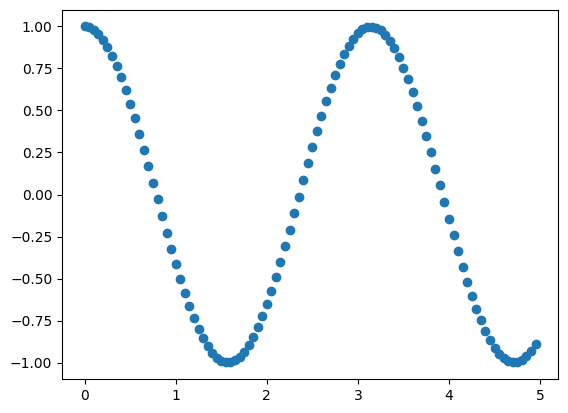

In [7]:
w = 2  # Frequência angular do oscilador

# Gero valores de 0 a 5 com passo 0.02 para o t.
# O requires_grad avisa ao PyTorch para acompanhar as operações com esse Tensor, para poder calcular a derivada depois.
t = torch.arange(start=0, end=5, step=0.05, requires_grad=True).unsqueeze(1)


def fun_x(t):
    """Função solução da EDO, usaremos para comparar com a PINN"""
    return torch.cos(w * t)


# Imprimir solução da EDO. Queremos que o gráfico gerado pela PINN seja igual a esse:
x = fun_x(t)
plt.plot(t.detach().numpy(), x.detach().numpy(), "o")
plt.show()

## 3. Criando a rede neural

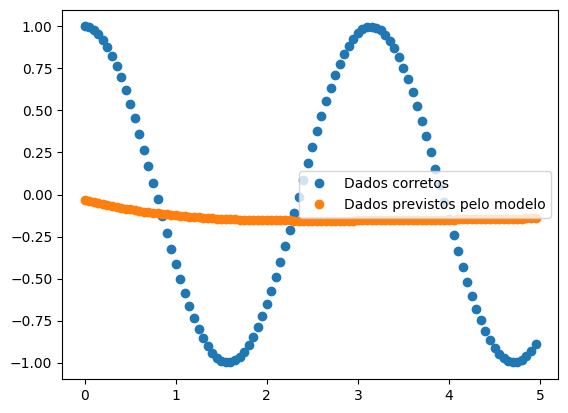

In [8]:
# Fixo uma seed para que os valores aleatórios sejam sempre os mesmos tanto para mim, quanto para você no seu computador.
torch.manual_seed(42)


class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Aqui as coisas mudaram bastante. Agora temos 3 camadas.
        # Uma de entrada com 1 neurônio, uma do meio (hidden) com 50 e outra de saída com um neurônio novamente
        # Temos uma variável de entrada e uma de saída pois função que estamos tentando encontrar tem uma entrada (t) e uma saída (x).
        # Como a nossa função não é linear, estamos usando o tangente hiperbólico como função de ativação entre as camadas.
        self.hidden_layer = nn.Sequential(
            # É obrigatório que a entrada de uma camada seja igual a saída da anterior.
            nn.Linear(1, 50),  # Essa recebe 1 valor e retorna 50 valores...
            nn.Tanh(),
            nn.Linear(50, 50),  # Essa entra 50 e retorna 50...
            nn.Tanh(),
            nn.Linear(50, 1),  # E por fim, essa recebe 50 valores e retorna 1.
        )

    def forward(self, t):
        return self.hidden_layer(t)


model = PINN()  # Criando uma instancia do modelo.

# Testando como está o modelo antes do treinamento.
# Espera-se que esteja bem diferente do objetivo
with torch.inference_mode():
    x_prev = model(t)  # Calcula os valores de x previstos pelo modelo.

plt.plot(t.detach().numpy(), x.detach().numpy(), "o", label="Dados corretos")
plt.plot(t.detach().numpy(), x_prev, "o", label="Dados previstos pelo modelo")
plt.legend()
plt.show()

## 4. Treinando a rede neural

A grande diferença aqui é que não temos dados para treinamento, temos apenas nossa equação diferencial e seus parâmetros iniciais. Então a função de loss ficou completamente diferente.

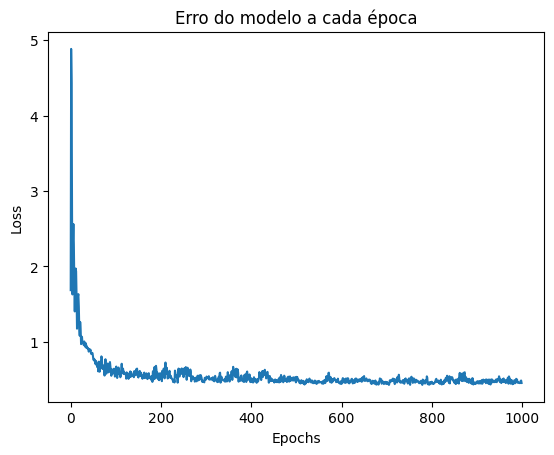

In [9]:
def loss_fn(model, t):
    # Calcula os valores de x previstos pelo modelo.
    x_pred = model(t)

    # A função grad (gradiente) calcula a derivada.
    # Aqui estamos calculando a derivada de x em relação a t (dt/dx).
    # Ou seja como o valor do x previsto pelo modelo varia ao variar o valor de t
    x_t = torch.autograd.grad(
        x_pred,
        t,
        grad_outputs=torch.ones_like(x_pred),
        create_graph=True,
    )[0]
    # Aqui calculamos a derivada segunda (d²t/dx²).
    # Como dt/dy irá variar quando variamos o valor de t?
    x_tt = torch.autograd.grad(
        x_t, t, grad_outputs=torch.ones_like(x_pred), create_graph=True
    )[0]

    # Perda da EDO. Tiramos a média do erro de vários valores de t.
    # Quanto mais proximo a função x(t) do modelo da função solução da EDO, mais proximo de zero o valor do loss vai estar.
    loss_EDO = torch.mean(torch.sqrt((x_tt + w * w * x_pred) ** 2))

    # Setando t0 = 0 e qual o valor de x(t0) e x'(t0) de acordo com o modelo
    t0 = torch.tensor([[0.0]], requires_grad=True)  # Tensor do valor de t=0
    x0_pred = model(t0)
    x0_t_pred = torch.autograd.grad(
        x0_pred, t0, grad_outputs=torch.ones_like(x0_pred), create_graph=True
    )[0]

    # Perda das condições iniciais.
    # O valor de x0_pred deveria ser um, de acordo com a primeira condição inicial. Então x0_pred - 1 tem que ser igual a 0
    # Já o valor de x0_t_pred tem que ser 0 para bater com a segunda condição inicial.
    loss_ic = torch.sqrt(torch.mean(x0_pred - 1) ** 2) + torch.sqrt(
        torch.mean(x0_t_pred) ** 2
    )

    # Perda total
    loss_total = 1 * loss_EDO + 1 * loss_ic
    return loss_total


# A função de otimização, vamos mantar ela com SGD por enquanto.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# N° de épocas
epochs = 1000

# Listas vazias que usaremos para montar o gráfico do loss
loss_values = []
epoch_count = []


# O Loop de treinamento
for epoch in range(epochs):
    # Coloca o modelo no modo de treinamento
    model.train()

    # Calcula o loss usando a nossa função loss.
    loss = loss_fn(model, t)

    # Ajusta os valores do modelo + detalhes de implementação do PyTorch. Não precisa se importar com isso, pelo menos por enquanto.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Guarda os valores de loss após cada época, isso vai nos ajudar a montar gráficos depois.
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())


plt.title("Erro do modelo a cada época")
plt.plot(epoch_count, loss_values)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

# 5. Testando nossa rede neural

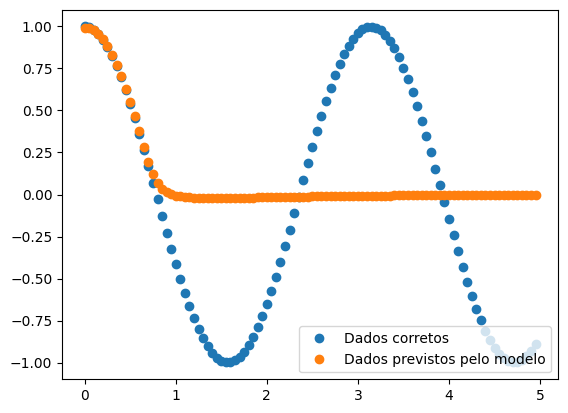

In [10]:
with torch.inference_mode():  # Coloca o modelo no modo de inferência
    x_prev = model(t)  # Calcula os valores de x previstos pelo modelo.

plt.plot(t.detach().numpy(), x.detach().numpy(), "o", label="Dados corretos")
plt.plot(t.detach().numpy(), x_prev, "o", label="Dados previstos pelo modelo")
plt.legend()
plt.show()

# 6. E agora?

A previsão da rede neural melhorou bastante após o treinamento. Mas você consegue deixar ela melhor ainda?

Uma forma bem fácil é aumentar o n° de épocas. Em vez de 100 coloque 200, 500, 1000...

Mas outra forma mais interessante é mudando as funções de perda e de otimização:

- Teste alterar os valores do parâmetro "lr" (o passo) da função de otimização. Valores maiores vão ajudar, mas será que valores grandes demais não vão acabar atrapalhando?

- E que tal sair do simples e em vez de utilizar o SGD utilizar outro algoritmo mais complexo como o Adam?
Dica: Substitua `torch.optim.SGD` por `torch.optim.Adam`. Ou teste outros algoritmos disponíveis na [documentação do PyTorch](https://pytorch.org/docs/stable/optim.html)

- E a função loss? Veja na [documentação](https://pytorch.org/docs/stable/nn.html#loss-functions) outras funções disponíveis.

Ah, sempre que você executar a etapa 4, execute antes a etapa 3 para instanciar o modelo novamente, se não ele tenta treinar o modelo que já foi treinado, que não é o que queremos.